# Kaggle Insurance Dataset

In this section I will use patient data from a Kaggle Insurance Dataset in order to predict the medical insurance cost for each person. I will perform exploratory data analysis and apply regression techniques of supervised learning to predict the insurance charges.

In [33]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.regression.linear_model as lm
from statsmodels.stats.outliers_influence import OLSInfluence

## Exploratory Data Analysis

First we load and have a first look at our dataset.

In [34]:
df = pd.read_csv("datasets_13720_18513_insurance.csv")
df.head()
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


We can see that columns 'age', 'bmi' and 'children' are numerical, while columns 'sex','smoker' and 'region' are categorical.
Column 'charges' is the values we are trying to predict and it is numerical, therefore we have to apply a regression model to predict these values.<br>

To analyse how the numerical columns 'age' and 'charge' behave against the 'charges' column we will use scatter plots:

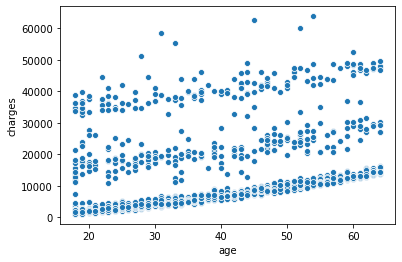

In [35]:
ageplot = sns.scatterplot(x="age", y="charges", data=df)

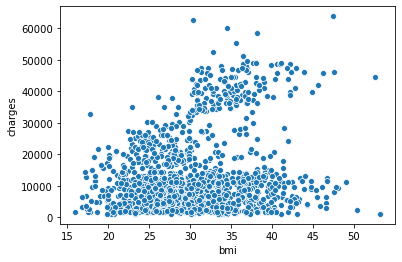

In [36]:
bmiplot = sns.scatterplot(x="bmi", y="charges", data=df)

We can see that in the first plot there are 3 visible groups/lines and in all there is a relatively linear trend upwards where the older the age, the higher the prices. This means that 'age' could be a good potential variable to include in a linear model to predict 'charges'.<br>

In the second plot there is a sort of trend of charges increasing with bmi but is not as clear as in the first plot. There  could be 2 groups within bmi that have different trend slopes.


Next we will review the behaviour of categorical variables 'sex','smoker','region' and 'children' against the 'charges' column. We will use box and whisker plots are they tend to be good graphs for visualizing categorical data.

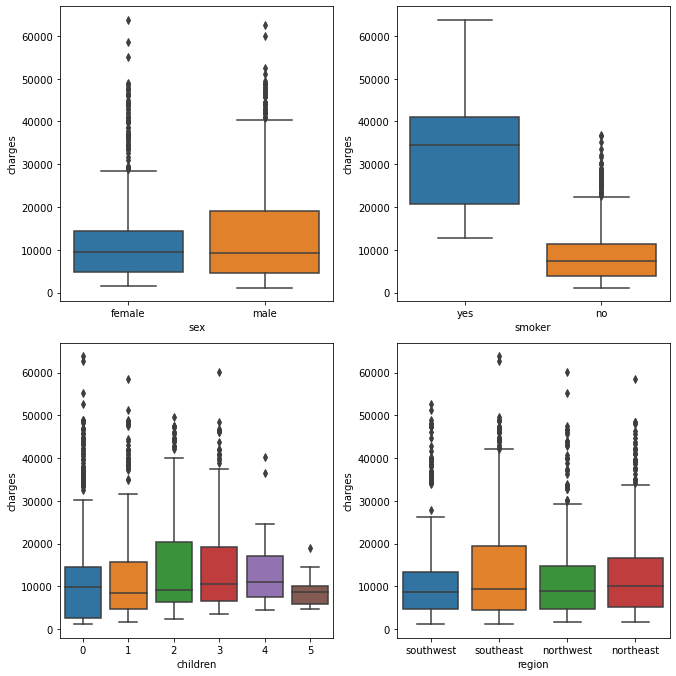

In [37]:
fig, axs = plt.subplots(2,2)
sexplot = sns.boxplot(x="sex", y="charges", data=df, ax=axs[0,0])
smokerplot = sns.boxplot(x="smoker", y="charges", data=df, ax=axs[0,1])
childrenplot = sns.boxplot(x="children", y="charges", data=df, ax=axs[1,0])
regionplot = sns.boxplot(x="region", y="charges", data=df, ax=axs[1,1])
fig.set_size_inches(9.5, 9.5)
fig.tight_layout()

Analysing the 1st graph, we can see that the mean charge in male and female is the same so we are not expecting the 'sex' variable to highly influence the charge. We see the same happening on the 4th graph where the mean of all regions is the same, so we are also not expecting this variable to have high influence. On the other hand we can see on the 2nd graph that the means and boxes of smokers and non-smokers are significantly different, smokers have higher insurance charges than non-smokers. We can infer that the 'smoker' column has a high influence on the charge.Finally, on the 3rd graph the means of the different children numbers are different but near each other, so the 'children' column might have some influence on the charges.

Next, we will plot a correlation matrix to validate if our previous assumptions of correlation between these variables and the charges are true. We will also check if there is any high correlation between input variables, as this could bring multicollinearity into our regression model and we want to avoid that to have in order to have a stable model.<br>

We will need to encode the categorical variables in order to build the correlation matrix. We will use sklearn's LabelEncoder to encode columns 'sex', 'smoker', and 'region'.

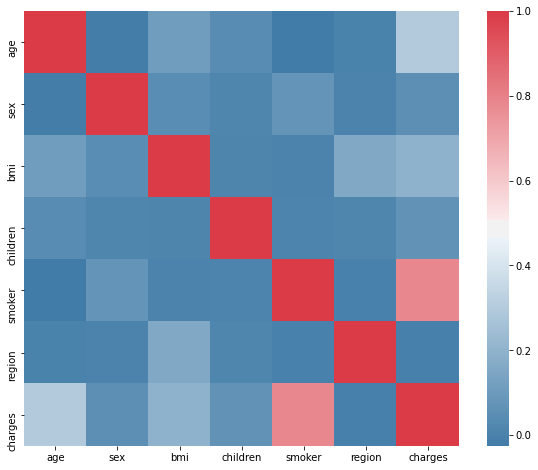

In [38]:
#encoding categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#sex
le.fit(df.sex) 
df.sex = le.transform(df.sex)
#smoker
le.fit(df.smoker) 
df.smoker = le.transform(df.smoker)
#region
le.fit(df.region) 
df.region = le.transform(df.region)

#Building the correlation matrix heatmap

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)


By looking at the correlation matrix we can confirm our previous assumption that smoking is highly correlated to the insurance charges. We can also see that, as previously suspected when looking at numerical columns vs charge scatteplots, age and bmi also have some correlation with the charges. Finally we see that there's no high correlation between input variables, which means that we will be able to build a fairly stable linear regression model with multiple variables. 

## Data Cleaning and Preprocessing

In this section we will perform a list of steps to clean and transform our data to ensure that it's ready for model ingestion. First, we check if there are any null values in the data that should be addressed.

In [39]:
#Check if there are any null values
df.isnull().values.any()

False

There are no null values that we have to address so we move to the next cleaning step, removing row duplicates from the data.

In [40]:
#Eliminate any duplicate rows in the dataframe
df.drop_duplicates(keep = False, inplace = True)

Next, we will perform one-hot-encoding on the 'region' column. We are performing this step to avoid using the ordinal values built before using LabelEncoder since we want to avoid the model treating this categorical column as ordinal.

In [41]:
#column region one-hot encoding
dum_region = pd.get_dummies(data = df["region"])
df["southwest"]=dum_region[3].to_list()
df["southeast"]=dum_region[2].to_list()
df["northwest"]=dum_region[1].to_list()
df["northeast"]=dum_region[0].to_list()
df.drop("region",axis='columns',inplace=True)
df

,age,sex,bmi,children,smoker,charges,southwest,southeast,northwest,northeast
0,19,0,27.900,0,1,16884.92400,1,0,0,0
1,18,1,33.770,1,0,1725.55230,0,1,0,0
2,28,1,33.000,3,0,4449.46200,0,1,0,0
3,33,1,22.705,0,0,21984.47061,0,0,1,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,0,1,0
1334,18,0,31.920,0,0,2205.98080,0,0,0,1
1335,18,0,36.850,0,0,1629.83350,0,1,0,0
1336,21,0,25.800,0,0,2007.94500,1,0,0,0


We drop column 'northeast' as it can be calculate using the 3 other region columns. 

In [42]:
df.drop("northeast",axis='columns',inplace=True)

## Model selection and evaluation

For this regression problem, we will use Ordinary Least Squares as our model for predicting the charges. Ordinary Least Squares (OLS) regression is a statistical method of analysis that estimates the relationship between one or more independent variables and a dependent variable; the method estimates the relationship by minimizing the sum of the squares in the difference between the observed and predicted values of the dependent variable configured as a straight line. 

We will use columns 'smoker', 'age' and 'bmi' as our predictors in the linear model since we've seen in previous charts that these columns have correlation with the charges. At this moment, we will not include any other input variable as we want to ensure that our model is parsimonious, with the least amount of independent variables capable of predicting the charges.

In [43]:
#preparing inputs (X) and target (Y)
X = df.loc[:,["smoker","bmi","age"]]
y = df.loc[:,"charges"]

#add an intercept constant value
X = sm.add_constant(X)

#fitting the model
model = lm.OLS(y,X).fit()

#summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1312.
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:42:06   Log-Likelihood:                -13538.
No. Observations:                1336   AIC:                         2.708e+04
Df Residuals:                    1332   BIC:                         2.710e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.167e+04    938.705    -12.428      0.000   -1.35e+04   -9825.031
smoker      2.382e+04    413.250     57.642      0.000     2.3e+04    2.46e+04
bmi          322.6702     27.507     11.730      0.000     268.708     376.632
age          259.3144     11.962     21.679      0.000     235.849     282.780
==============================================================================
Omnibus:                      298.590   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              705.516
Skew:                           1.212   Prob(JB):                    6.30e-154
Kurtosis:                       5.608   Cond. No.                         289.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
#type(X.iloc[1])


model.predict([1,1,30,50])

array([34799.96592855])

In [55]:
X.iloc[1]

const      1.00
smoker     0.00
bmi       33.77
age       18.00
Name: 1, dtype: float64

After fitting our model, we can see that the model has an R-squared of 0.747 which means that the model is perfoming quite well and is capable of predicting most of the variance in the charges (R-squared is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model, it varies from 0 to 1, with 1 being a perfect model fit)

We can also see that the P-value for the intercept value as well as the three variables 'smoker', 'bmi' and 'age' is below 0.001 which means that all variables are significant to the model.


Now, we can to make sure that our model is not being largely affected by any outliers with high influence, as these outliers could be negatively affect the fit of our model. To measure if there are any outliers in our data we will use Cook’s distance. Cook’s distance shows the influence of each observation on the fitted response values. An observation with Cook’s distance larger than three times the mean Cook’s distance might be an outlier. 

<ipython-input-14-fa479629e768>:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(distance, basefmt=" ")


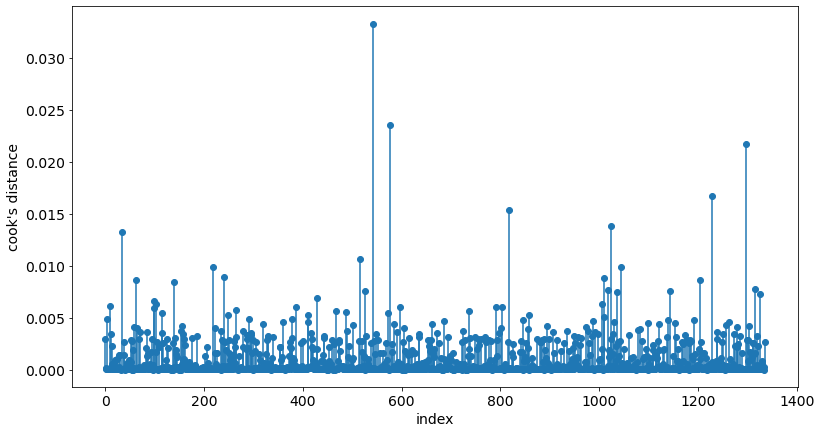

In [14]:
#plot size
plt.figure(figsize=(13,7))

# calculate the cooks_distance - the OLSInfluence object contains multiple influence measurements
cook_distance = OLSInfluence(model).cooks_distance
(distance, p_value) = cook_distance


# stem plot - the x-axis represents the index of the observation and the y-axis its Cook's distance
plt.stem(distance, basefmt=" ")

# the observations with Cook's distances higher than the threshold value are labeled in the plot
influencial_data = distance[distance]

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('index', fontsize=14)
plt.ylabel('cook\'s distance', fontsize=14)

plt.show()

All values have a Cook's distance lower than 1, therefore we can assume there are no influencial outlier cases.

Finally, using the trained model I will create a function that can predict the insurance charges of a person given the person's smoker status, bmi and age.

In [72]:
def predict_charges(smoker, bmi, age):
    return print("The predicted insurance charge is: "+str(round(model.predict([1,smoker,bmi,age])[0],2)))

#Using the predict_charges function with user input values
predict_charges(smoker=0,bmi=34,age=42)

The predicted insurance charge is: 10195.46


## Next Steps

For futher analysis, different multivariate regression models could be built by adding combinations of the remaining columns 'region', 'sex' and 'children' to the already used variables in our model. The models could be compared to find and choose the one that predicts the most variability in the charges, as we as to obtain more insights into the behaviour of the variables in the dataset. 

# Sklearn Breast Cancer Dataset
In this section I will load the breast cancer dataset available from the sklearn package which contains patient information and indicates whether a patient has breast cancer or not. I will then perform exploratory data analysis, identify the algorithm suitable to detecting breast cancer and present appropriate performance metrics.

## Data Load

In [80]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.DataFrame(data.target,columns =['target'])

## Exploratory Data Analysis
First we load and have a first look at our dataset.

In [75]:
X.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


All the data in our data set is numerical so there won't be a need to encode any categorical variables. Next, we have a look at the target value which should tell if the pacient has breast cancer or not and it's distribution.

In [76]:
print(y.head(5))

#distribution of values in the target column
y['target'].value_counts()

   target
0       0
1       0
2       0
3       0
4       0


1    357
0    212
Name: target, dtype: int64

We see that the target already is encoded to 0's and 1's where 1 means the patient has cancer. We also see that there are more patients in the dataset with cancer than patients without cancer, yet the difference is not huge so our model won't have issues training properly for both cases. 

# Data Cleaning and Preprocessing

In this section we will perform a list of steps to clean and transform our data to ensure that it's ready for model ingestion. First, we check if there are any null values in the data that should be addressed.

In [82]:
#Check if there are any null values
X.isnull().values.any()

False

There are no null values that we have to address so we move to the next cleaning step, checking if there are any duplicate rows in the dataset and if so, removing them.

In [83]:
dups = X[X.duplicated(subset=None, keep='first')]
dups

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension


There are no duplicates in the data. As we can see, this dataset is already quite clean and ordered so we will move on to the next section.

## Model Selection

This is a binary classification problem as we are trying to predict is a patient has cancer or not. We will use a Decision Tree algorithm as it tends to be good model and it's widely used for predicting classification problems.

The goal of using a Decision Tree is to create a training model that can use to predict the class or value of the target variable by learning simple decision rules inferred from prior data(training data). In Decision Trees, for predicting a class label for a record we start from the root of the tree. We compare the values of the root attribute with the record’s attribute. On the basis of comparison, we follow the branch corresponding to that value and jump to the next node.

First we will split the data into a training dataset that will be used to train our model and a test dataset to evaluate the perfomance of the model and it's capacity to generalize to new unseen data.

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

Next we will fit our decision tree model with the training data. We will 'prune'  the tree to only 4 levels of depth as we want to avoid our model overfitting, by just picking 4 levels our model should be able to generalize well to new data.

In [85]:
#Model fitting
clf = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 8,
                            random_state = 0).fit(X_train, y_train)

Below we plot the fitted decision tree model.

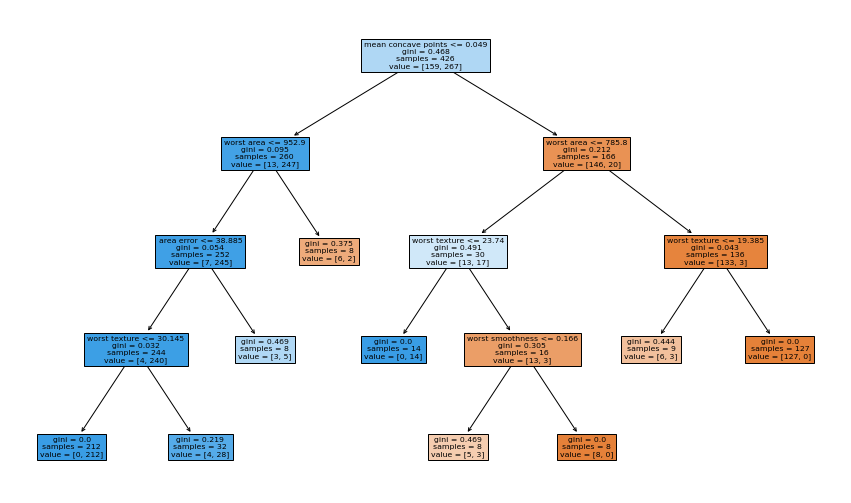

In [86]:
#plot size
plt.figure(figsize=(15,9))

#feature names
fn = list(X.columns) 

#plot_decision_tree(clf, cancer.feature_names, cancer.target_names)
sk.tree.plot_tree(clf,feature_names = fn, filled=True, max_depth=4)
plt.show()

The above graph show how the data is split into the 4 levels of depth in the decision tree. We can see that columns 'mean concave points','worst area', 'worst texture', 'area texture' and 'worst_smoothness' are being used as the main columns for splitting the data so we can suspect that these are important features. In order to confirm this and to investigate what other features are most influencial to the model we plot the decision tree's feature importances.

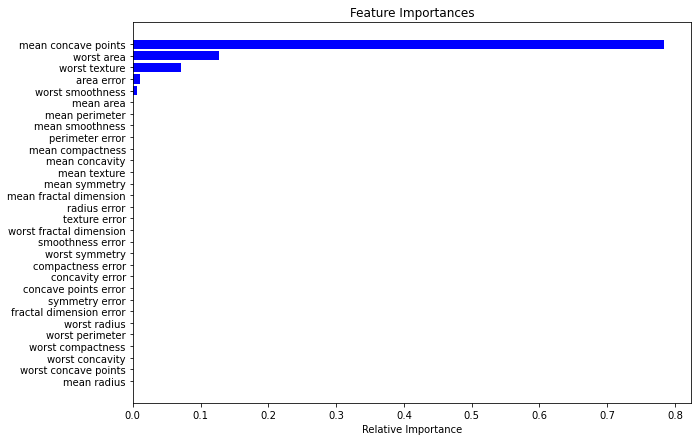

In [87]:
#plot size
plt.figure(figsize=(10,7))

#feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [fn[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Looking at the graph above we can confirm that 'mean concave points','worst area', 'worst texture', 'area texture' and 'worst_smoothness' are the most important variables for predicting breast cancer. 'Mean concave points' in particular is the main predictor for breat cancer, having around 80% influence on the prediction outcome.

## Model Evaluation
Now we will use different metrics to evaluate our model's performance against the training data and the test data. We will discuss and look at the main metrics to use for this particular problem.

First we evaluate our model on the training data.

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#predicting the target Y
tree_predicted = clf.predict(X_train)

#Confusion Matrix
print('Confusion Matrix: ')
print(confusion_matrix(y_train, tree_predicted))

# Accuracy = TP + TN / (TP + TN + FP + FN)
print('Accuracy: {:.2f}'.format(accuracy_score(y_train, tree_predicted)))

# Precision = TP / (TP + FP)
print('Precision: {:.2f}'.format(precision_score(y_train, tree_predicted)))
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
print('Recall: {:.2f}'.format(recall_score(y_train, tree_predicted)))

# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('F1: {:.2f}'.format(f1_score(y_train, tree_predicted)))

Confusion Matrix: 
[[152   7]
 [  8 259]]
Accuracy: 0.96
Precision: 0.97
Recall: 0.97
F1: 0.97


Our model predicts a high accuracy and F1 score in the training data, the confusion matrix also show low false negatives and false positives. Let's evaluate it now on the test data.

In [27]:
#predicting the target Y
tree_predicted = clf.predict(X_test)

#Confusion Matrix
print('Confusion Matrix: ')
print(confusion_matrix(y_test, tree_predicted))

# Accuracy = TP + TN / (TP + TN + FP + FN)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_predicted)))

# Precision = TP / (TP + FP)
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predicted)))
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predicted)))

# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('F1: {:.2f}'.format(f1_score(y_test, tree_predicted)))

Confusion Matrix: 
[[52  1]
 [ 8 82]]
Accuracy: 0.94
Precision: 0.99
Recall: 0.91
F1: 0.95


Even though the Accuracy, Recall and F1 score have slightly decreased the model is still showing great performance with all evaluation values above 90%, this means that our model is generalizing well to new data. The false negatives in the confusion matrix are slightly more significant in comparison to the total patients in the test data.

Now we want to focus on the Recall score. Recall calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Therefore, Recall is a model metric that should be used when there is a high cost associated with having a false negative. In this case, a false negative could mean that the model missed the fact that the patient actually has cancer, putting his/her life at risk which is something that should be avoided at all cost, so we want the model's Recall to be as high as possible.

Lets plot a Precision-Recall curve to see the relation between Precision and Recall, and determine if we can improve the Recall in the model.

<ipython-input-28-2f5299d2e387>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


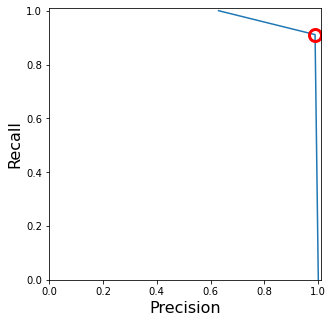

In [28]:
from sklearn.metrics import precision_recall_curve

#Calculating precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, tree_predicted)
closest_zero = np.argmax(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

#plotting the curve
plt.figure(figsize=(7,5))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

In the Precision-Recall curve we can see in the red circle where the model is at the moment, having 0.99 Precision and a 0.91 Recall. But we can also see in the graph that we can improve the Recall at the cost of lowering the Precision. In order to accomplish this we first have a look at the Predict Probabilities characteristics of the model for each patient.

In [29]:
y_proba_lr = clf.predict_proba(X_test)
y_proba_list = list(zip(y_test['target'].values, y_proba_lr[:,1]))
y_proba_list

[(0, 0.0),
 (1, 0.875),
 (1, 1.0),
 (1, 1.0),
 (1, 1.0),
 (1, 1.0),
 (1, 1.0),
 (1, 1.0),
 (1, 0.875),
 (1, 1.0),
 (1, 0.3333333333333333),
 (1, 1.0),
 (1, 1.0),
 (1, 0.25),
 (1, 0.3333333333333333),
 (0, 0.3333333333333333),
 (1, 1.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (1, 1.0),
 (1, 1.0),
 (0, 0.0),
 (1, 1.0),
 (1, 1.0),
 (0, 0.375),
 (1, 1.0),
 (0, 0.0),
 (1, 1.0),
 (0, 0.0),
 (1, 1.0),
 (0, 0.0),
 (1, 1.0),
 (0, 0.0),
 (1, 1.0),
 (0, 0.0),
 (1, 1.0),
 (0, 0.0),
 (0, 0.625),
 (1, 1.0),
 (0, 0.25),
 (1, 1.0),
 (1, 1.0),
 (0, 0.0),
 (1, 1.0),
 (1, 0.875),
 (1, 1.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.375),
 (0, 0.0),
 (1, 1.0),
 (1, 1.0),
 (1, 1.0),
 (1, 0.875),
 (1, 0.875),
 (1, 0.875),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (1, 1.0),
 (1, 1.0),
 (0, 0.0),
 (1, 0.625),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (1, 0.875),
 (1, 1.0),
 (0, 0.0),
 (1, 1.0),
 (0, 0.375),
 (0, 0.0),
 (1, 0.875),
 (1, 1.0),
 (1, 0.375),
 (1, 1.0),
 (1, 1.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (1, 1.0),
 

Here, we can see that in some cases the model is predicting 0 even when it has 33% and higher confidence levels that it might actually be cancer. Since we want the model to be highly conservative to improve its Recall, we will set its Decision Threshold to 0.25, so that if the model has a higher confidence than this value it will predict a positive.

In [30]:
#setting new decision threshold
THRESHOLD = 0.25
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

#Confusion Matrix
print('Confusion Matrix: ')
print(confusion_matrix(y_test, preds))

# Accuracy = TP + TN / (TP + TN + FP + FN)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, preds)))

# Precision = TP / (TP + FP)
print('Precision: {:.2f}'.format(precision_score(y_test, preds)))
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
print('Recall: {:.2f}'.format(recall_score(y_test, preds)))

# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('F1: {:.2f}'.format(f1_score(y_test, preds)))

Confusion Matrix: 
[[47  6]
 [ 3 87]]
Accuracy: 0.94
Precision: 0.94
Recall: 0.97
F1: 0.95


## Conclusion

After adjusting the decision threshold we can see that the Recall has improved from 0.91 to 0.97 which is a great result for our particular problem. Now, as seen in the Confusion Matrix, the model only predicts 3 false negatives. The Accuracy, Precision and F1 have slightly decreased but they are still higher than 90% so we accept this tradeoff in order to keep model with high Recall score.